# Doc2Vec

In [1]:
import collections
import glob
from itertools import chain
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

In [2]:
files = glob.glob('*.txt')

words = []
for f in files:
    file = open(f)
    words.append(file.read())
    file.close()

words = list(chain.from_iterable(words))
words = ''.join(words)[:-1]
sentences = words.split('\n')

In [3]:
len(sentences)

50000

In [4]:
vocabulary_size = 40000

def build_dataset(sentences):
    words = ''.join(sentences).split()
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    unk_count = 0
    sent_data = []
    for sentence in sentences:
        data = []
        for word in sentence.split():
            if word in dictionary:
                index = dictionary[word]
            else:
                index = 0  # dictionary['UNK']
                unk_count = unk_count + 1
            data.append(index)
        sent_data.append(data)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return sent_data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(sentences)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:2])
# del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 97408], ('the', 667723), ('and', 324431), ('a', 322940), ('of', 289409)]
Sample data [[279, 174, 436, 7068, 46, 3387, 43, 3, 15, 16, 223, 1128, 72, 1706, 1166, 37, 1, 1308, 1603, 2147, 836, 4, 61, 39, 25, 53, 172, 9, 41, 117, 23, 453, 44, 99, 4, 1, 101, 89, 4, 178, 27, 2986, 8, 1, 4181, 2, 7068, 12, 104, 25, 1654, 399, 22, 2, 92, 1502, 364, 73, 304, 33, 61, 57, 9, 117, 23, 453, 1, 104, 70, 142, 64, 453, 44, 6, 3, 53, 9647, 34287, 9806, 9245, 1, 444, 6, 24, 270, 122, 14, 516, 35, 1236, 24, 12, 127, 72, 244, 322, 184, 86, 2, 273, 56, 3784, 4, 3, 17257, 4181, 26, 62, 13216, 721, 5, 29, 1707, 121, 7068, 414, 51, 70, 25, 69, 501, 1, 302, 95, 218, 4, 10, 3890, 7068, 703, 178, 30, 44, 9245, 12, 2986, 70, 25, 556, 134, 9245, 6, 2100, 5, 29, 1, 118, 17, 56, 2515, 15677, 40, 11184, 56, 1313, 129, 7, 13, 30, 9, 96, 78, 5, 387, 37, 1596, 7, 122, 34, 519, 8], [10, 6, 34, 464, 4, 134, 1, 2216, 4, 205, 105, 25, 1, 168, 3859, 2, 347, 39, 12, 64, 163, 276, 149, 129, 3,

## Tensorflow Model

In [5]:
skip_window = 3
instances = 0

# Pad sentence with skip_windows
for i in range(len(data)):
    data[i] = [vocabulary_size]*skip_window+data[i]+[vocabulary_size]*skip_window

# Check how many training samples that we get    
for sentence  in data:
    instances += len(sentence)-2*skip_window
print(instances)    

11708957


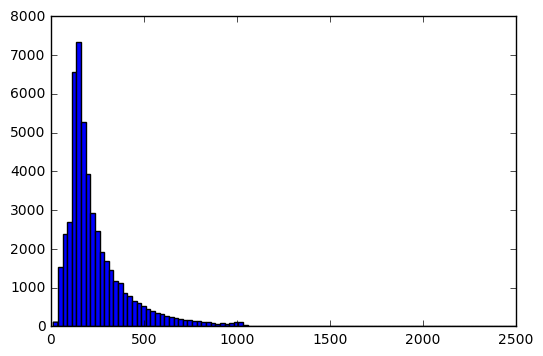

In [6]:
sent_len = np.array([len(d) for d in data])
plt.hist(sent_len,100)
plt.show()

In [9]:
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)
doc = np.zeros((instances,1),dtype=np.int32)

k = 0
for doc_id, sentence  in enumerate(data):
    for i in range(skip_window, len(sentence)-skip_window):
#         buffer = sentence[i-skip_window:i+skip_window+1]
#         labels[k] = sentence[i]
#         del buffer[skip_window]
#         context[k] = buffer
#         doc[k] = doc_id
#         k += 1
        context[k] = sentence[i-skip_window:i+skip_window+1] # Get surrounding words
        labels[k] = sentence[i] # Get target variable
        doc[k] = doc_id
        k += 1
        
context = np.delete(context,skip_window,1) # delete the middle word        
        
shuffle_idx = np.random.permutation(k)
labels = labels[shuffle_idx]
doc = doc[shuffle_idx]
context = context[shuffle_idx]

In [16]:
batch_size = 256
context_window = 2*skip_window
embedding_size = 50 # Dimension of the embedding vector.
softmax_width = embedding_size # +embedding_size2+embedding_size3
num_sampled = 5 # Number of negative examples to sample.
sum_ids = np.repeat(np.arange(batch_size),context_window)

len_docs = len(data)

graph = tf.Graph()

with graph.as_default(): # , tf.device('/cpu:0')
    # Input data.
    train_word_dataset = tf.placeholder(tf.int32, shape=[batch_size*context_window])
    train_doc_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    segment_ids = tf.constant(sum_ids, dtype=tf.int32)

    word_embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    word_embeddings = tf.concat([word_embeddings,tf.zeros((1,embedding_size))],0)
    doc_embeddings = tf.Variable(tf.random_uniform([len_docs,embedding_size],-1.0,1.0))

    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, softmax_width],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed_words = tf.segment_mean(tf.nn.embedding_lookup(word_embeddings, train_word_dataset),segment_ids)
    embed_docs = tf.nn.embedding_lookup(doc_embeddings, train_doc_dataset)
    embed = (embed_words+embed_docs)/2.0#+embed_hash+embed_users

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.nce_loss(softmax_weights, softmax_biases, train_labels, 
                                         embed, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)
        
    norm = tf.sqrt(tf.reduce_sum(tf.square(doc_embeddings), 1, keep_dims=True))
    normalized_doc_embeddings = doc_embeddings / norm

In [17]:
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_doc_data = doc[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_doc_data = np.vstack([doc[data_idx:instances],doc[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data, batch_doc_data

In [ ]:
num_steps = 1000001
step_delta = int(num_steps/20)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_word_data, batch_doc_data\
        = generate_batch(batch_size)
        feed_dict = {train_word_dataset : np.squeeze(batch_word_data),
                     train_doc_dataset : np.squeeze(batch_doc_data),
                     train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % step_delta == 0:
            if step > 0:
                average_loss = average_loss / step_delta
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

    # Get the weights to save for later
#     final_doc_embeddings = normalized_doc_embeddings.eval()
    final_word_embeddings = word_embeddings.eval()
    final_word_embeddings_out = softmax_weights.eval()
    final_doc_embeddings = normalized_doc_embeddings.eval()

Initialized
Average loss at step 0: 20.908936


In [61]:
# rand_doc = np.random.randint(len_docs)
dist = final_doc_embeddings.dot(final_doc_embeddings[rand_doc][:,None])
closest_doc = np.argsort(dist,axis=0)[-4:][::-1]
furthest_doc = np.argsort(dist,axis=0)[0][::-1]

for idx in closest_doc:
    print(dist[idx][0][0])
    
print(dist[furthest_doc][0][0])    

1.0
0.529682
0.520041
0.516757
-0.588134


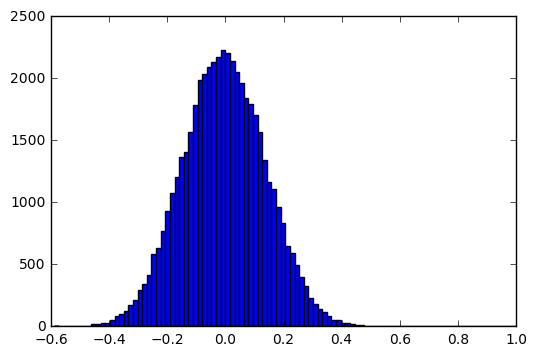

In [59]:
plt.hist(dist,100)
plt.show()

In [55]:
sentences[rand_doc]

'this show comes up with interesting locations as fast as the travel channel it is billed as reality but in actuality it is pure prime time soap opera it s tries to use exotic locales as a facade to bring people into a phony contest then proceeds to hook viewers on the contestants soap opera style it also borrows from an early cbs game show pioneer beat the clock by inventing situations for its contestants to try overcome then it rewards the winner money if they can spice it up with a little interaction between the characters even better while the game format is in slow motion versus beat the clock the real accomplishment of this series is to escape reality this show has elements of several types of successful past programs reality television hardly but if your hooked on the contestants locale or contest this is your cup of tea if your not this entire series is as i say drivel dripping with gravy it is another show hiding behind the reality label which is the trend it started in it is 

In [56]:
sentences[closest_doc[1][0]]

'in a way you have to respect arachnia it s clearly meant as a tribute to the big bug movies of the fifties and while the special effects look terrible at least the film doesn t feature cgi however on the other hand you can t respect the film too much because it s a load of rubbish the acting is terrible the special effects as mentioned are impossible to take seriously and once you ve seen one giant spider being blown up you ve seen them all so it gets boring rather quickly the plot follows a bunch of people who are unlucky enough to be in a plane crash after a meteor shower they go to the only house in the area which just happens to be a house where a man has a huge spider he used to use as a circus attraction coincidently around the same time the meteor shower has caused more giant spiders to rise from underground all the characters in this film are poor caricatures none of them have anything even resembling a third dimension and they will soon begin to thoroughly bore you you ve got

In [57]:
sentences[closest_doc[2][0]]

'star rating saturday night friday night friday morning sunday night monday morning mr bean rowan atkinson is in this world but not of this world his mind simply doesn t seem to comprehend things the way an average person would and his life is one long disaster because of this getting himself into constant mishaps and far out zany situations which he is left to sort out on his own as he doesn t seem to mix with anyone and he rarely speaks but he never gives up and despite the simplest of tasks being a constant struggle for him applying his own zany methods of solving the problem always pays off for him in the end to look at the sorry state of modern british humour with all it s focus of sex and general vulgarity you d be forgiven for forgetting that a show like mr bean was made at one time there s nothing unsuitable going on here just good clean u rated humour of the type tommy cooper and the like made in the s and i find it just as laugh out loud funny now in my early s as i did when 

In [58]:
sentences[closest_doc[3][0]]

'when i went to see this movie it was already a forced choice as my original intent was sold out what ensuited then was sheer terror this movie is so bad i could hardly bear it the story is not worth mention a gay goalkeeper forms a gay soccer team to play against his old straight team who on discovering his sexual orientation gave him a hard time loaded with unbearably old and overused clich s of gays the thin plot matches perfectly the inane dialogues it is absolutely astonishing that actors as dietmar b r or charly h bner waste their talent and time on such nonsense '

In [64]:
sentences[furthest_doc[0]]

'wwii veterans return home and find it hard to adjust to civilian life this superb drama is expertly directed by wyler and beautifully filmed by famed cinematographer toland despite its near three hour length it does not drag for a minute the script by sherwood features very human characters and great dialog andrews has perhaps his best role as a man struggling to make ends meet also good are wright as a love sick young woman mayo as andrews trampy wife and real life veteran russell as a man who lost both his hands however top honors go to march and loy as a long married couple facing challenges while getting reacquainted with each other '

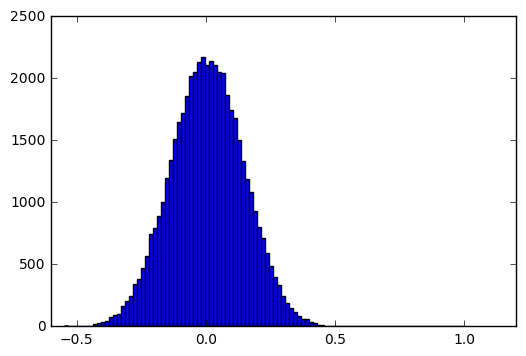

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(dist,100)
plt.show()

## Gensim Model

In [65]:
import gensim
from gensim.models import Doc2Vec
from multiprocessing import cpu_count

cpus = cpu_count()

/Users/sachin/anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [66]:
def read_corpus():
    for i,sentence in enumerate(words.split('\n')):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sentence), [i])

train_corpus = list(read_corpus())

In [155]:
model = Doc2Vec(dm=1, dm_concat=0, size=embedding_size, window=skip_window, 
                negative=5,hs=0, min_count=5, workers=cpus, iter=2)
model.build_vocab(train_corpus)

In [156]:
%%time
model.train(train_corpus)

CPU times: user 26min 22s, sys: 1.86 s, total: 26min 23s
Wall time: 3min 26s


21854570

In [182]:
closest_doc2 = model.docvecs.most_similar([model.docvecs[rand_doc]],topn=4)
for _, sim in closest_doc2:
    print(sim)

1.0
0.8846234083175659
0.8725295066833496
0.8673354387283325


In [178]:
sentences[rand_doc]

'peter crawford discovers a comet on a collision course with the moon but when the government doesn t believe him dumb fact he builds a shelter in deep underground and is drawing lots to see who will go plus is willing to kill to save humanity dumb fact with millions of dollars of technology how could a civilian see what nasa could not plus the ends justifies the means moral of this story is just plain wrong this movie is improbable and totally unbelievable what was running through these people minds why the hell do crap piles like this get the green light some times i wonder who someone has to to get a movie made in this ing town '

In [179]:
sentences[closest_doc2[1][0]]

'the title of this documentary is very misleading at no time during the documentary do they show how the introduction of the nile perch fish into lake victoria has cause any of the problems facing the town of mwanza tanzania the film tries to place the problems of tanzania on an environmental cause but the truth of that matter is the problems stem from a parasitic outside force the documentary is very slowing paced with no narrative what so ever instead it relies on small blips of text between none related segments to display bits of information that do little to add or expand of the subject matter there are only two attempts to discus the environmental effects of the nile perch fish one is a small segment about seconds long where they interview the factory managers where the fish is processed and he briefly mentions how years ago the nile perch was introduced into the lake and it consumed the other fish species the film maker makes no attempt to follow up on the matter or go deeper in

In [180]:
sentences[closest_doc2[2][0]]

'this could have been great the voice overs are exactly right and fit the characters to a t one small problem though the look of the characters mostly the supporting or guest characters look exactly the same the same bored look on every face only with minor changes such as hairlines or weight size it looks kind of odd to see a really big guest star s voice coming out of a lifeless form like the characters here if i am not mistaken kathy griffin did a voice over for this show and it looked too odd to be funny there is a few other problems one being the family plot the simpsons did it much better where you could actually buy most of the situations the characters got themselves into here we get too much annoying diversions like someone having a weird fantasy and then we are supposed to find that funny but for some reason the delivery is a bit off as you can probably tell it is hard for me to put a finger on exactly what is wrong with this show because it basically nothing more than a clon

In [181]:
sentences[closest_doc2[3][0]]

'i like many folks believe the epic lonesome dove was one of the best westerns ever produced maybe the best and realizing that most sequels in this case a prequel are certain to disappoint my expectations were low comanche moon met that expectation with its marginal directing and acting poor casting and frankly a lousy script lonesome dove created western heroes of captains mccrae and call due to incredibly strong performances by robert duvall and tommy lee jones prior to living in lonesome dove we believed they bravely fought to rid texas of bandits and savage indians during their rangering years if i had only seen comanche moon i would think these two boneheads were a couple of incompetent cowardly idiots in lonesome dove call and mccrae supposedly chased blue duck all over texas and never managed to capture or kill him in comanche moon a shot to call s boot heel convinced him to settle down and raise cattle there wasn t a decent fistfight or gun fight in the entire miniseries the be

(50000, 50)

In [196]:
norm_vec = np.array([vec for vec in model.docvecs])
norm_vec = norm_vec/np.sqrt(np.sum(np.square(norm_vec),axis=1,keepdims=True))

norm_vec[rand_doc].dot(norm_vec[closest_doc2[1][0]])

0.88462347